In [1]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import cheetah

In [2]:
lattice_file_path = (
    Path("$LCLS_LATTICE") / "bmad" / "models" / "cu_hxr" / "cu_hxr.lat.bmad"
)
lattice_file_path

PosixPath('$LCLS_LATTICE/bmad/models/cu_hxr/cu_hxr.lat.bmad')

In [3]:
lattice_dir = str((Path(".").absolute().parent / "lcls-lattice"))

In [4]:
segment = cheetah.Segment.from_bmad(
    str(lattice_file_path), environment_variables={"LCLS_LATTICE": lattice_dir}
)
segment = segment.flattened()
segment

Segment([Drift(length=-0.87, name="dl00", device="cpu"), Drift(length=0.87, name="loadlock", device="cpu"), Marker(name=beggun, device="cpu"), Solenoid(length=0.00, k=0.00, misalignment=(0, 0), name="sol1bk", device="cpu"), Marker(name=dbmark80, device="cpu"), Marker(name=cathode, device="cpu"), Drift(length=0.10, name="dl01a", device="cpu"), Solenoid(length=0.20, k=0.00, misalignment=(0, 0), name="sol1", device="cpu"), Drift(length=0.08, name="dl01a1", device="cpu"), Marker(name=vv01, device="cpu"), Drift(length=0.12, name="dl01a2", device="cpu"), Marker(name=am00, device="cpu"), Drift(length=0.10, name="dl01a3", device="cpu"), Marker(name=am01, device="cpu"), Drift(length=0.02, name="dl01a4", device="cpu"), Marker(name=yag01, device="cpu"), Drift(length=0.01, name="dl01a5", device="cpu"), Marker(name=fc01, device="cpu"), Drift(length=0.08, name="dl01b", device="cpu"), Marker(name=im01, device="cpu"), Drift(length=0.13, name="dl01c", device="cpu"), HorizontalCorrector(length=0.00, ang

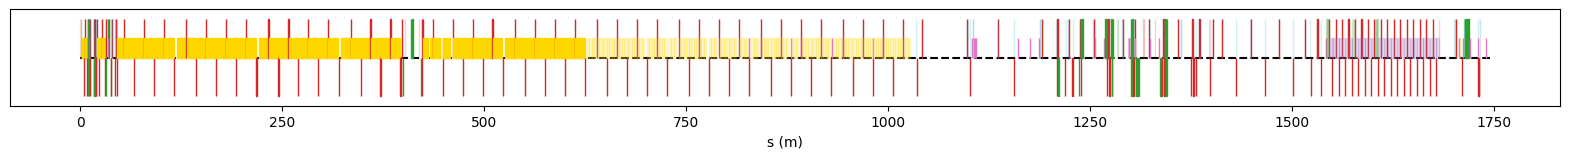

In [5]:
plt.figure(figsize=(20, 1.25))
segment.plot(ax=plt.gca(), s=0.0)

/Users/jankaiser/Documents/DESY/cheetah/cheetah/accelerator.py:1912: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


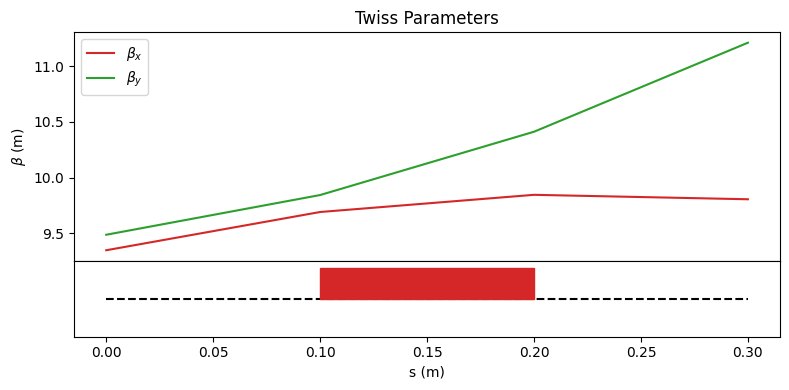

In [6]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=9.34799999999386,
    alpha_x=-1.69459999999829,
    emittance_x=3.494768647122823e-09,
    beta_y=9.48702794424903,
    alpha_y=-1.75970623484325,
    emittance_y=3.497810737006068e-09,
)

mini_segment = cheetah.Segment(
    [
        cheetah.Drift(length=0.1),
        cheetah.Quadrupole(length=0.1, k1=2.0),
        cheetah.Drift(length=0.1),
    ]
)

mini_segment.plot_twiss_over_lattice(beam)

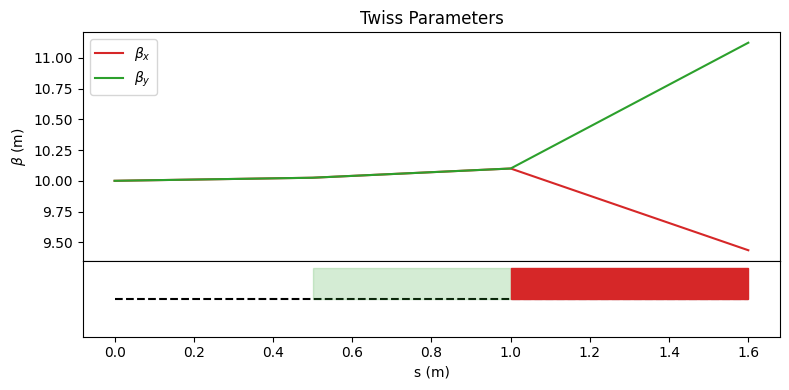

In [7]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=10.0,
    alpha_x=0.0,
    emittance_x=3.494768647122823e-09,
    beta_y=10.0,
    alpha_y=0.0,
    emittance_y=3.497810737006068e-09,
)
segment = cheetah.Segment.from_bmad("test/bmad/bmad_tutorial_lattice.bmad")
segment.plot_twiss_over_lattice(beam)

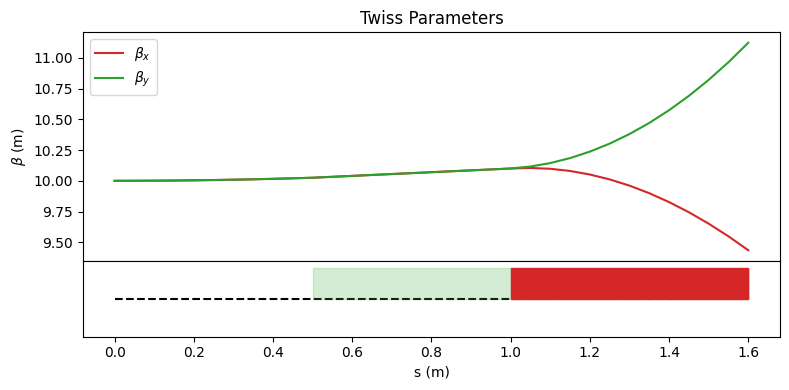

In [8]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=10.0,
    alpha_x=0.0,
    emittance_x=3.494768647122823e-09,
    beta_y=10.0,
    alpha_y=0.0,
    emittance_y=3.497810737006068e-09,
)
segment = cheetah.Segment.from_bmad("test/bmad/bmad_tutorial_lattice.bmad")
split_segment = cheetah.Segment(segment.split(0.05))
split_segment.plot_twiss_over_lattice(beam)

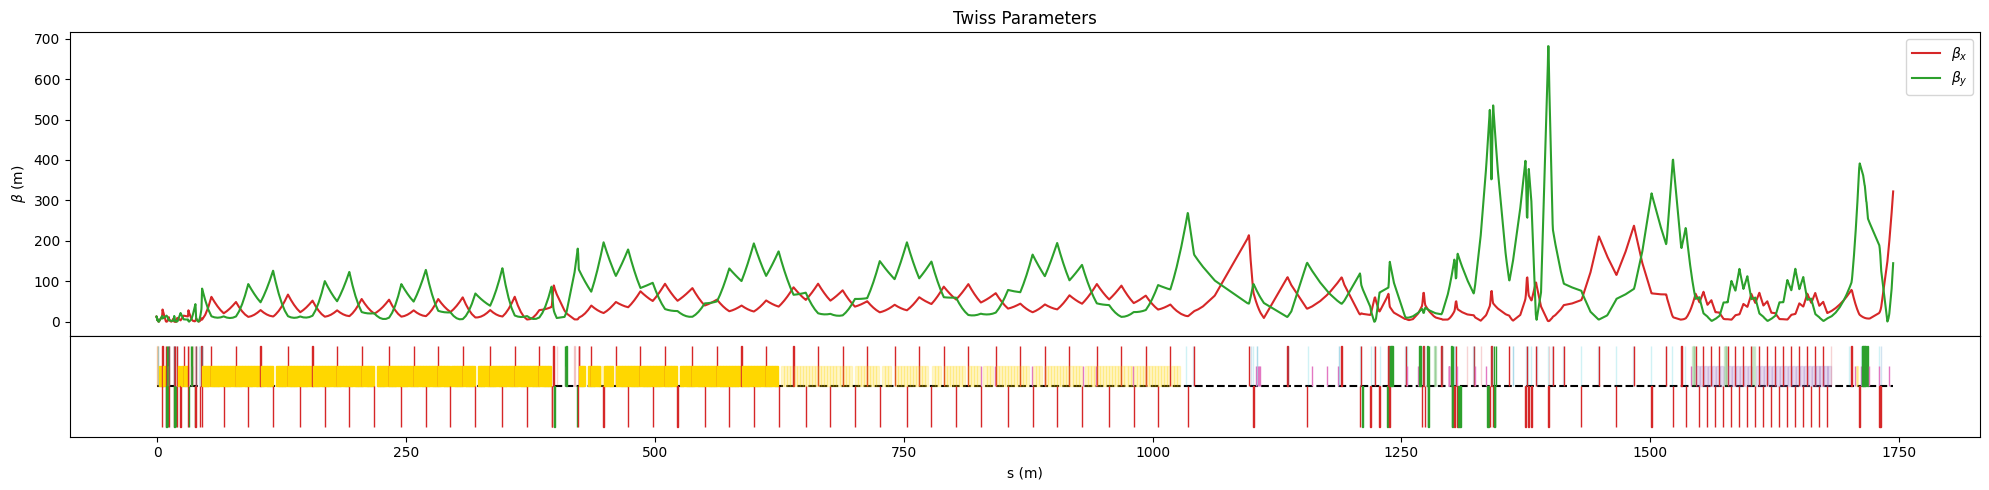

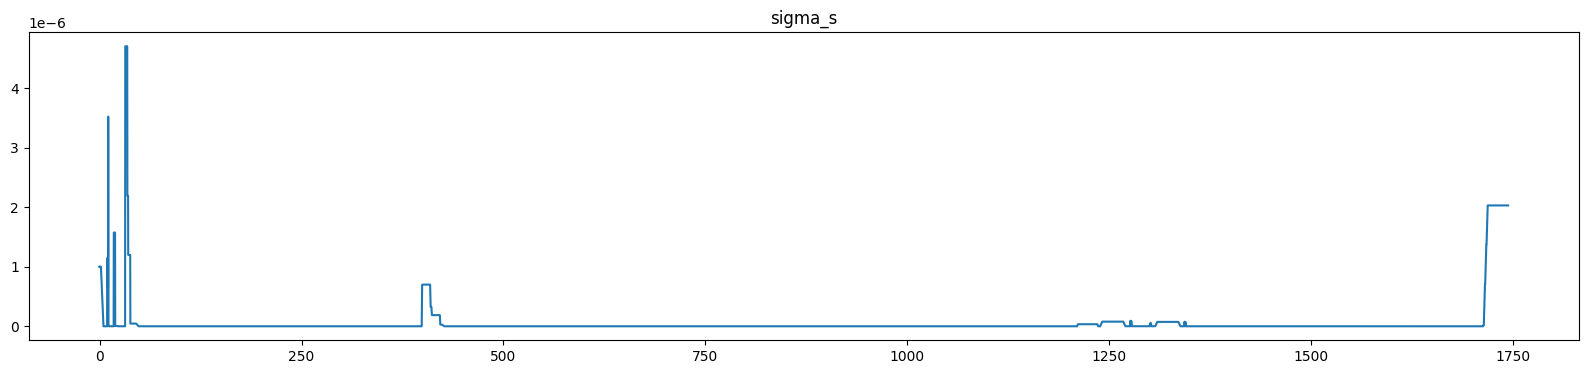

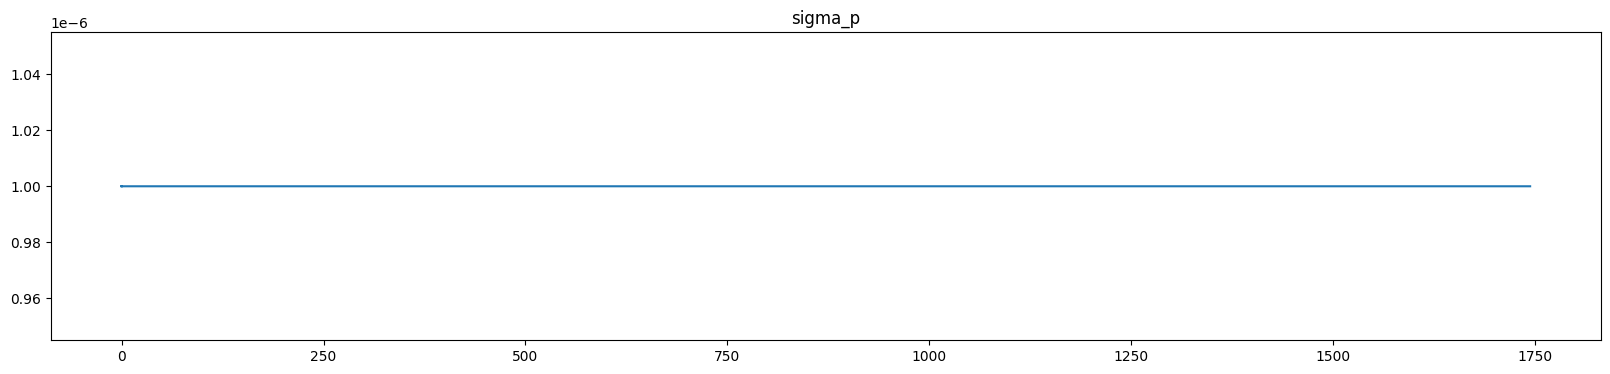

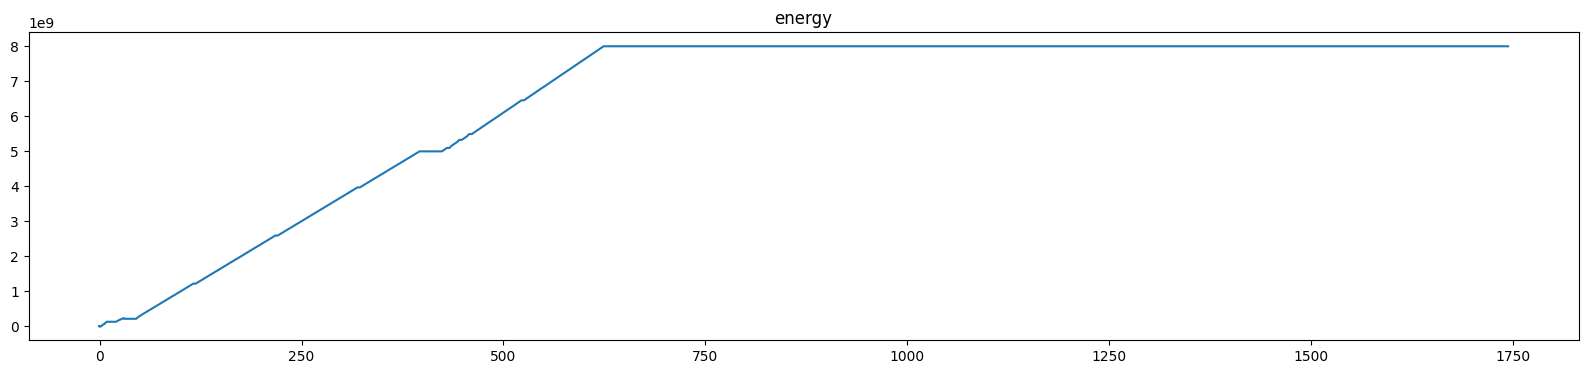

In [9]:
beam = cheetah.ParameterBeam.from_twiss(
    beta_x=5.91253677,
    alpha_x=3.55631308,
    emittance_x=3.494768647122823e-09,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)

segment = cheetah.Segment.from_bmad(
    str(lattice_file_path), environment_variables={"LCLS_LATTICE": lattice_dir}
)
segment = segment.flattened()
# segment = cheetah.Segment([element for element in segment.elements[:100]])

# outgoing = segment.track(beam)

segment.plot_twiss_over_lattice(beam, figsize=(20, 5))

# ------------------------------

longitudinal_beams = [beam]
s_positions = [0.0]
for element in segment.elements:
    if not hasattr(element, "length") or element.length == 0:
        continue

    outgoing = element.track(longitudinal_beams[-1])

    longitudinal_beams.append(outgoing)
    s_positions.append(s_positions[-1] + element.length)

sigma_s = [beam.sigma_s for beam in longitudinal_beams]
sigma_p = [beam.sigma_p for beam in longitudinal_beams]
energy = [beam.energy for beam in longitudinal_beams]

plt.figure(figsize=(20, 4))
plt.title("sigma_s")
plt.plot(s_positions, sigma_s)
plt.show()

plt.figure(figsize=(20, 4))
plt.title("sigma_p")
plt.plot(s_positions, sigma_p)
plt.show()

plt.figure(figsize=(20, 4))
plt.title("energy")
plt.plot(s_positions, energy)
plt.show()

In [10]:
segment.dl00

Drift(length=-0.87, name="dl00", device="cpu")

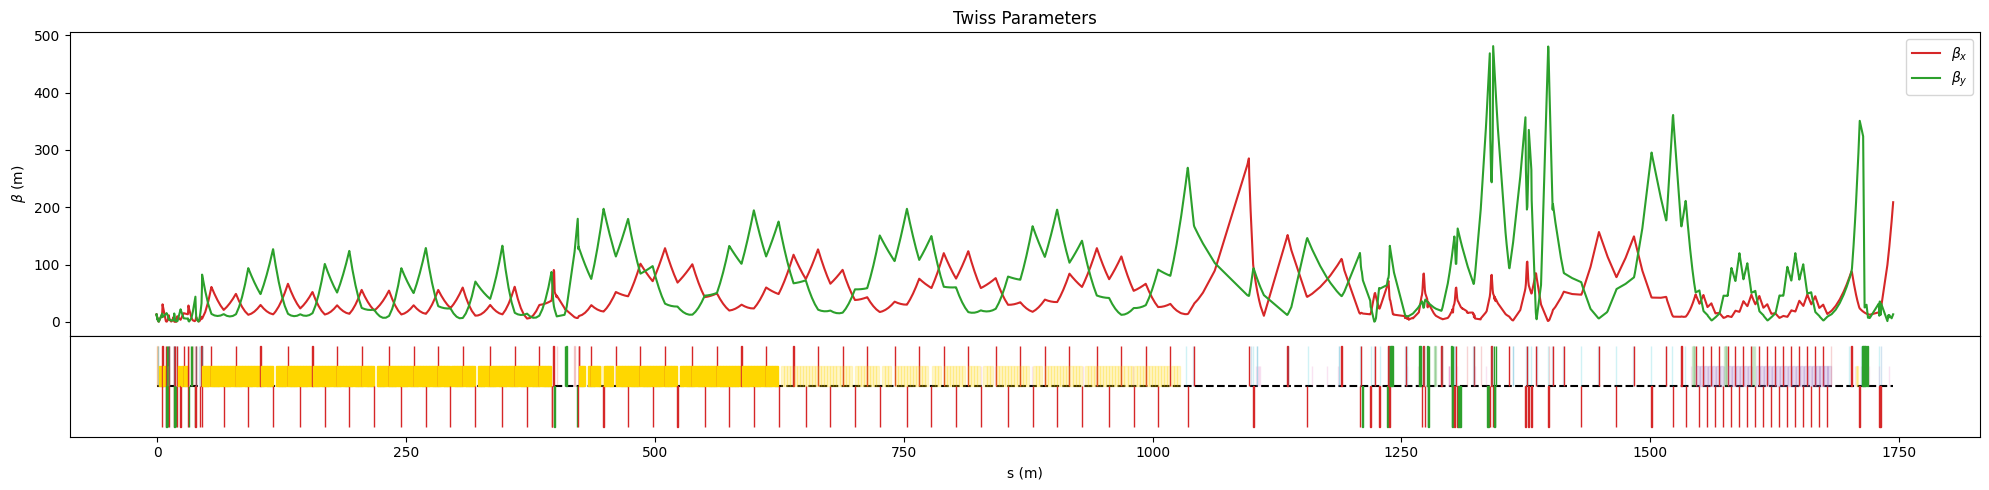

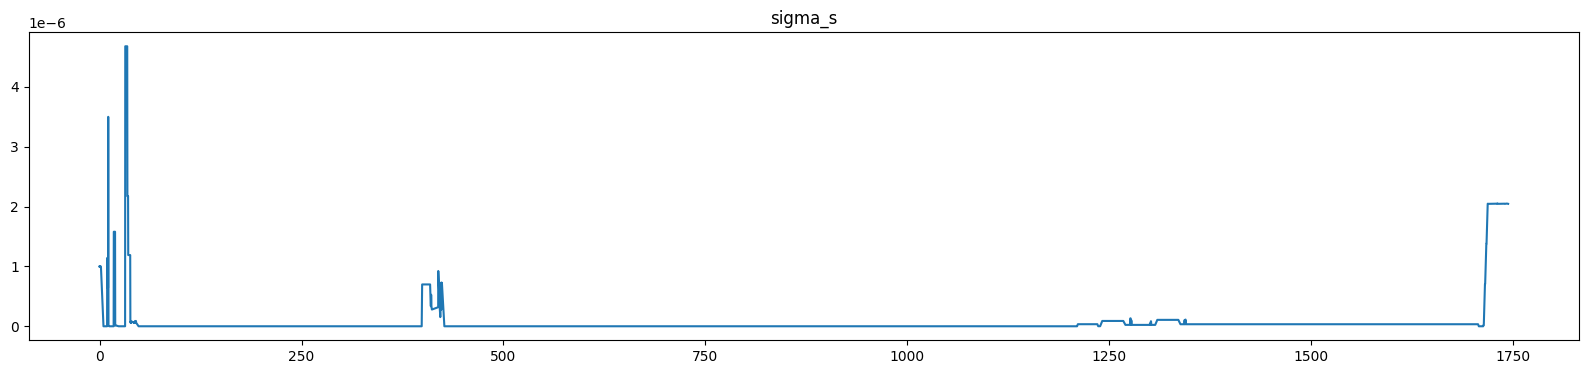

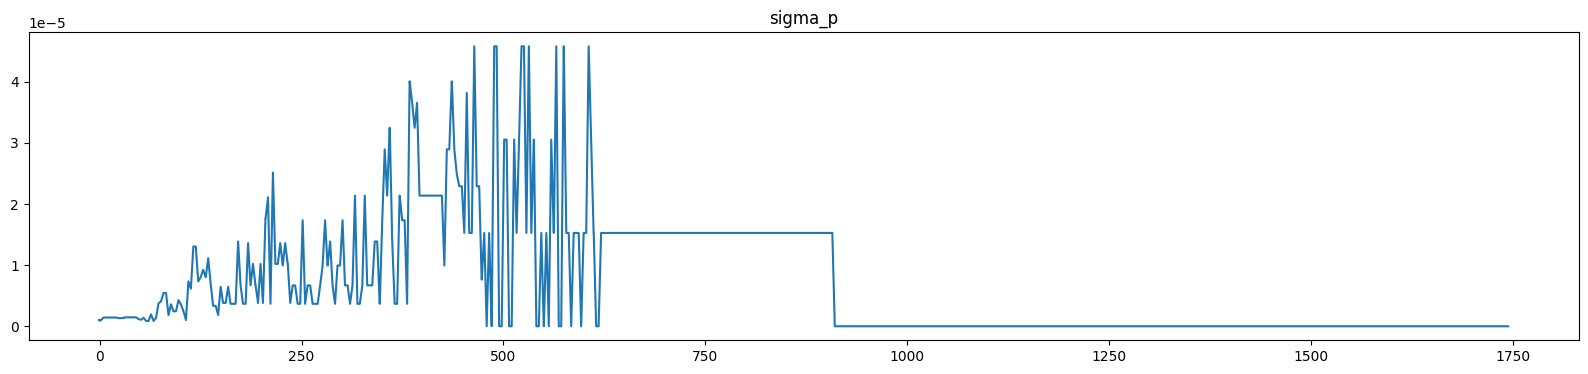

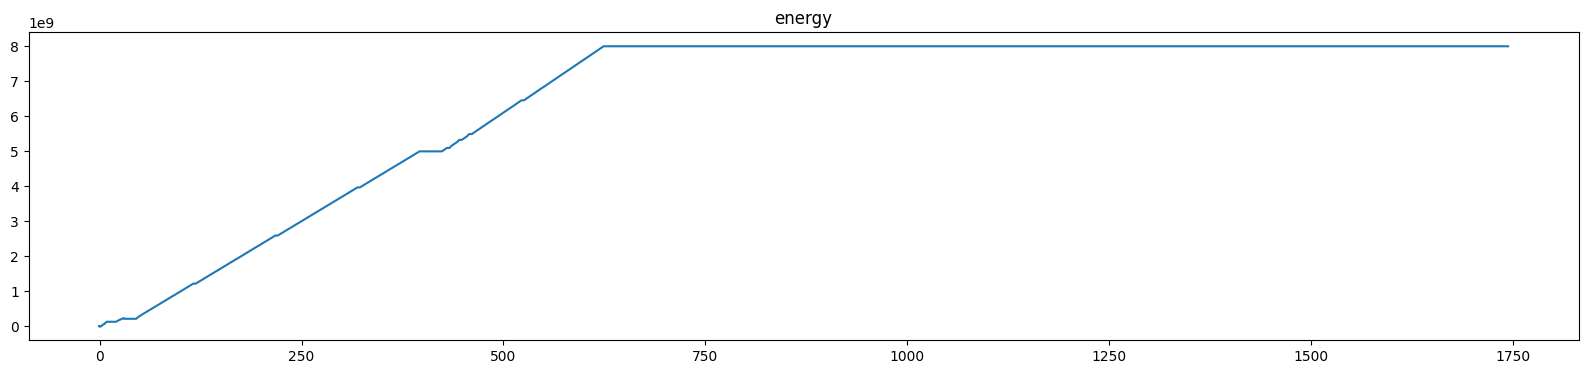

In [11]:
beam = cheetah.ParticleBeam.from_twiss(
    num_particles=10_000,
    beta_x=5.91253677,
    alpha_x=3.55631308,
    emittance_x=3.494768647122823e-09,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)

segment = cheetah.Segment.from_bmad(
    str(lattice_file_path), environment_variables={"LCLS_LATTICE": lattice_dir}
)
segment = segment.flattened()
for element in segment.elements:
    if isinstance(element, cheetah.Aperture):
        element.is_active = False
# segment = cheetah.Segment([element for element in segment.elements[:100]])

# outgoing = segment.track(beam)

segment.plot_twiss_over_lattice(beam, figsize=(20, 5))

# ------------------------------

longitudinal_beams = [beam]
s_positions = [0.0]
for element in segment.elements:
    if not hasattr(element, "length") or element.length == 0:
        continue

    outgoing = element.track(longitudinal_beams[-1])

    longitudinal_beams.append(outgoing)
    s_positions.append(s_positions[-1] + element.length)

sigma_s = [beam.sigma_s for beam in longitudinal_beams]
sigma_p = [beam.sigma_p for beam in longitudinal_beams]
energy = [beam.energy for beam in longitudinal_beams]

plt.figure(figsize=(20, 4))
plt.title("sigma_s")
plt.plot(s_positions, sigma_s)
plt.show()

plt.figure(figsize=(20, 4))
plt.title("sigma_p")
plt.plot(s_positions, sigma_p)
plt.show()

plt.figure(figsize=(20, 4))
plt.title("energy")
plt.plot(s_positions, energy)
plt.show()

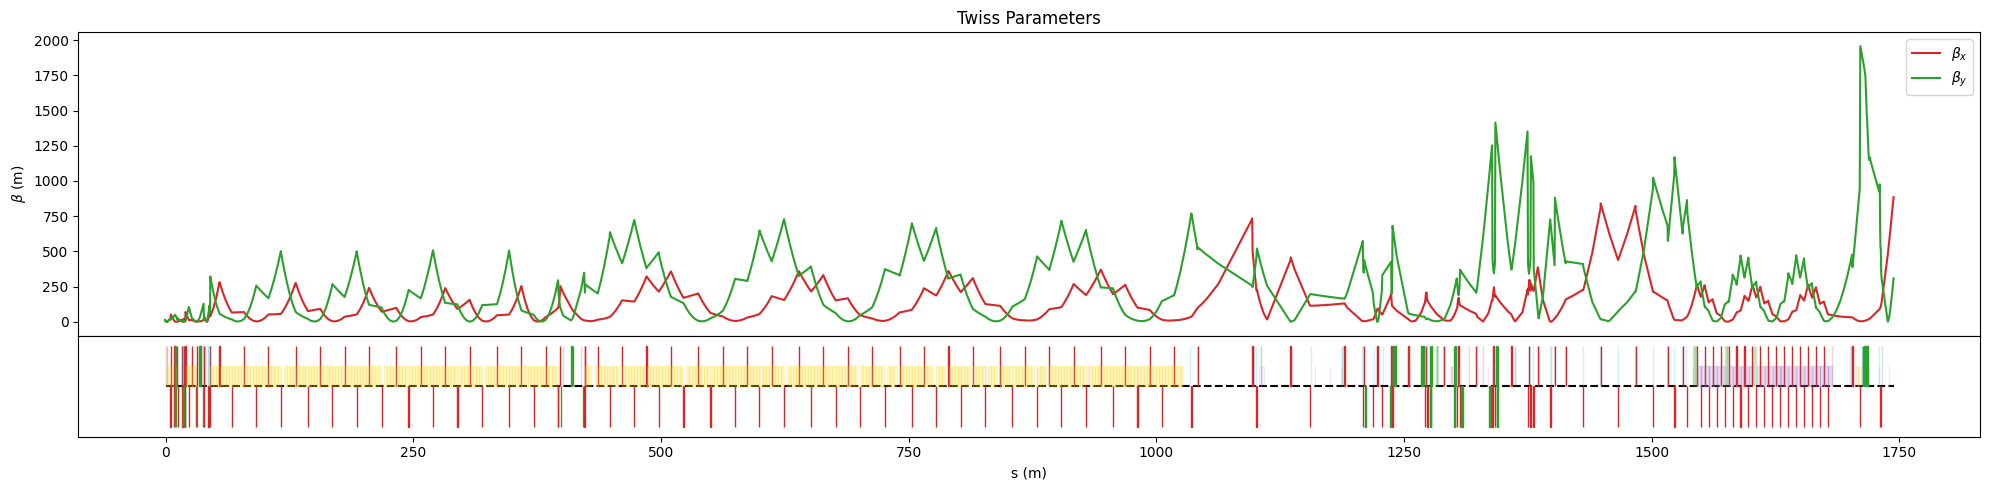

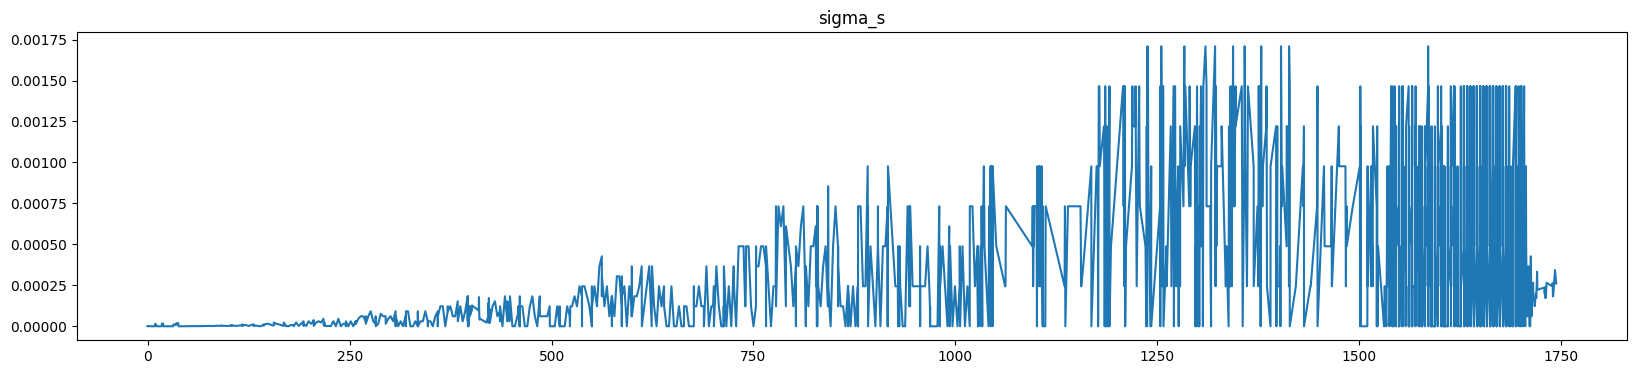

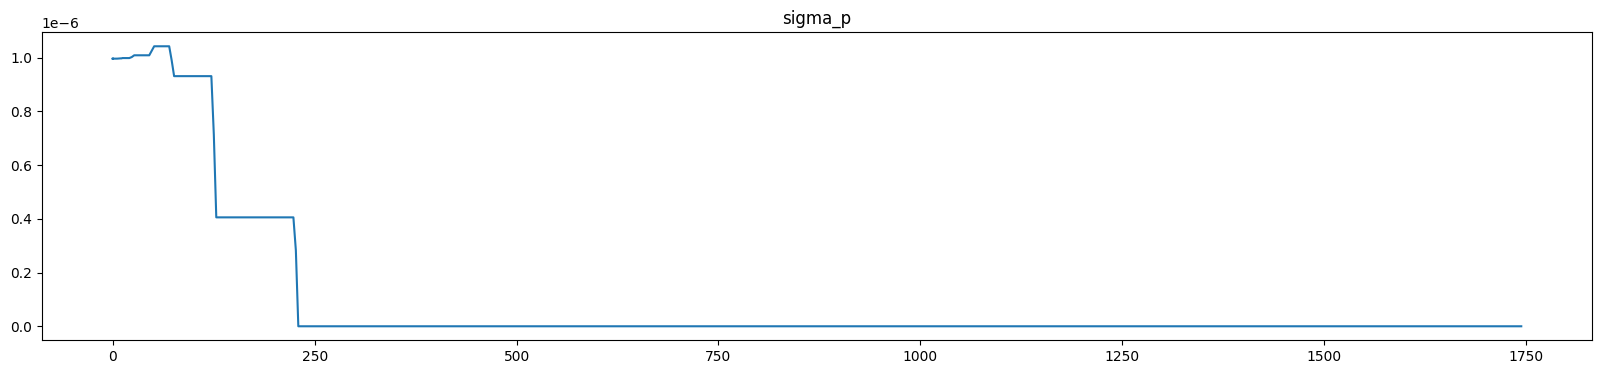

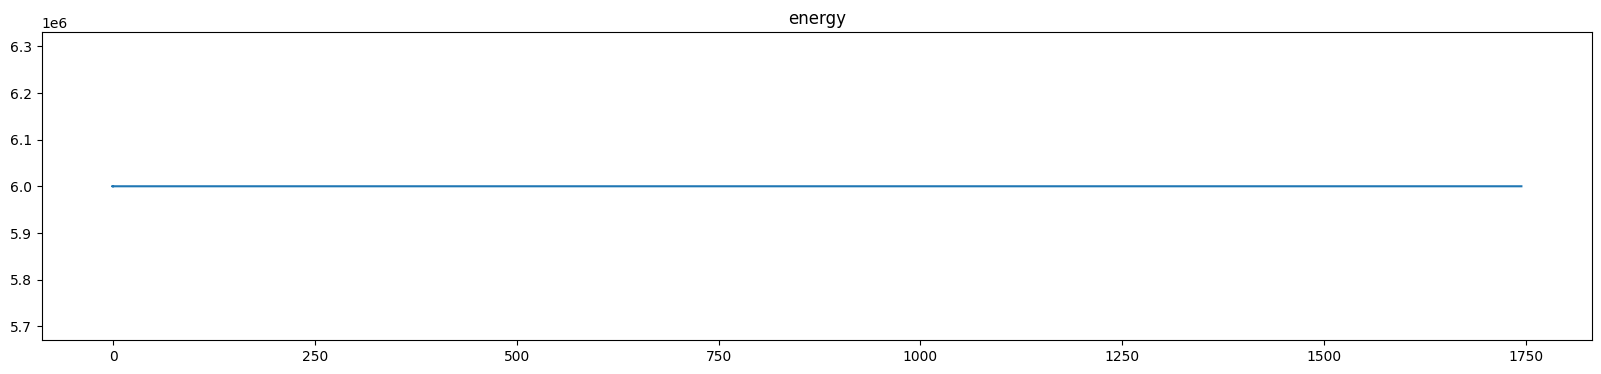

In [12]:
beam = cheetah.ParticleBeam.from_twiss(
    num_particles=10_000,
    beta_x=5.91253677,
    alpha_x=3.55631308,
    emittance_x=3.494768647122823e-09,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)

segment_copy = cheetah.Segment.from_bmad(
    str(lattice_file_path), environment_variables={"LCLS_LATTICE": lattice_dir}
)
segment_copy = segment_copy.flattened()
for element in segment_copy.elements:
    if isinstance(element, cheetah.Aperture):
        element.is_active = False
for element in segment_copy.elements:
    if isinstance(element, cheetah.Cavity):
        element.voltage = 0
# segment_copy = cheetah.Segment_copy([element for element in segment_copy.elements[:100]])

# outgoing = segment_copy.track(beam)

segment_copy.plot_twiss_over_lattice(beam, figsize=(20, 5))

# ------------------------------

longitudinal_beams = [beam]
s_positions = [0.0]
for element in segment_copy.elements:
    if not hasattr(element, "length") or element.length == 0:
        continue

    outgoing = element.track(longitudinal_beams[-1])

    longitudinal_beams.append(outgoing)
    s_positions.append(s_positions[-1] + element.length)

sigma_s = [beam.sigma_s for beam in longitudinal_beams]
sigma_p = [beam.sigma_p for beam in longitudinal_beams]
energy = [beam.energy for beam in longitudinal_beams]

plt.figure(figsize=(20, 4))
plt.title("sigma_s")
plt.plot(s_positions, sigma_s)
plt.show()

plt.figure(figsize=(20, 4))
plt.title("sigma_p")
plt.plot(s_positions, sigma_p)
plt.show()

plt.figure(figsize=(20, 4))
plt.title("energy")
plt.plot(s_positions, energy)
plt.show()

In [13]:
segment

Segment([Drift(length=-0.87, name="dl00", device="cpu"), Drift(length=0.87, name="loadlock", device="cpu"), Marker(name=beggun, device="cpu"), Solenoid(length=0.00, k=0.00, misalignment=(0, 0), name="sol1bk", device="cpu"), Marker(name=dbmark80, device="cpu"), Marker(name=cathode, device="cpu"), Drift(length=0.10, name="dl01a", device="cpu"), Solenoid(length=0.20, k=0.00, misalignment=(0, 0), name="sol1", device="cpu"), Drift(length=0.08, name="dl01a1", device="cpu"), Marker(name=vv01, device="cpu"), Drift(length=0.12, name="dl01a2", device="cpu"), Marker(name=am00, device="cpu"), Drift(length=0.10, name="dl01a3", device="cpu"), Marker(name=am01, device="cpu"), Drift(length=0.02, name="dl01a4", device="cpu"), Marker(name=yag01, device="cpu"), Drift(length=0.01, name="dl01a5", device="cpu"), Marker(name=fc01, device="cpu"), Drift(length=0.08, name="dl01b", device="cpu"), Marker(name=im01, device="cpu"), Drift(length=0.13, name="dl01c", device="cpu"), HorizontalCorrector(length=0.00, ang

In [14]:
print(f"{beam.beta_x = }")
print(f"{beam.beta_y = }")

beam.beta_x = tensor(5.7860)
beam.beta_y = tensor(6.0483)


In [37]:
beam_stepped = beam
for element in segment.elements[:39]:
    beam_stepped = element.track(beam_stepped)

print(f"{element.name = }")
print(f"{beam_stepped.beta_x = }")
print(f"{beam_stepped.beta_y = }")
print(f"{beam_stepped.alpha_x = }")
print(f"{beam_stepped.alpha_y = }")
print(f"{beam_stepped.energy = }")
print(f"{segment.l0a.phase = }")

element.name = 'l0a'
beam_stepped.beta_x = tensor(12.5934)
beam_stepped.beta_y = tensor(13.1527)
beam_stepped.alpha_x = tensor(-3.4415)
beam_stepped.alpha_y = tensor(-3.6063)
beam_stepped.energy = tensor(64000000., dtype=torch.float64)
segment.l0a.phase = 1.0999999999999999


In [16]:
segment.daq1

[Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device="cpu"),
 Drift(length=0.03, name="daq1", device=

In [17]:
for i, element in enumerate(segment.elements):
    if element.name == "q26201":
        break

In [18]:
segment.elements[i - 3].name, segment.elements[i - 2].name

('k26_1c', 'k26_1d')

In [19]:
segment.k26_1d

Cavity(length=3.04, voltage=48198469.20, phase=-0.00, frequency=2856000000.00, name="k26_1d", device="cpu")

In [20]:
segment.q26201

Quadrupole(length=0.11, k1=0.388844133085, misalignment=(0, 0), tilt=0.00, name="q26201", device="cpu")

In [21]:
quad_segment = segment.subcell("k26_1d", "begundh")

In [22]:
quad_segment.q26301

Quadrupole(length=0.11, k1=-0.405381176356, misalignment=(0, 0), tilt=0.00, name="q26301", device="cpu")

In [23]:
for element in quad_segment.elements:
    if isinstance(element, cheetah.Cavity):
        element.voltage = 0

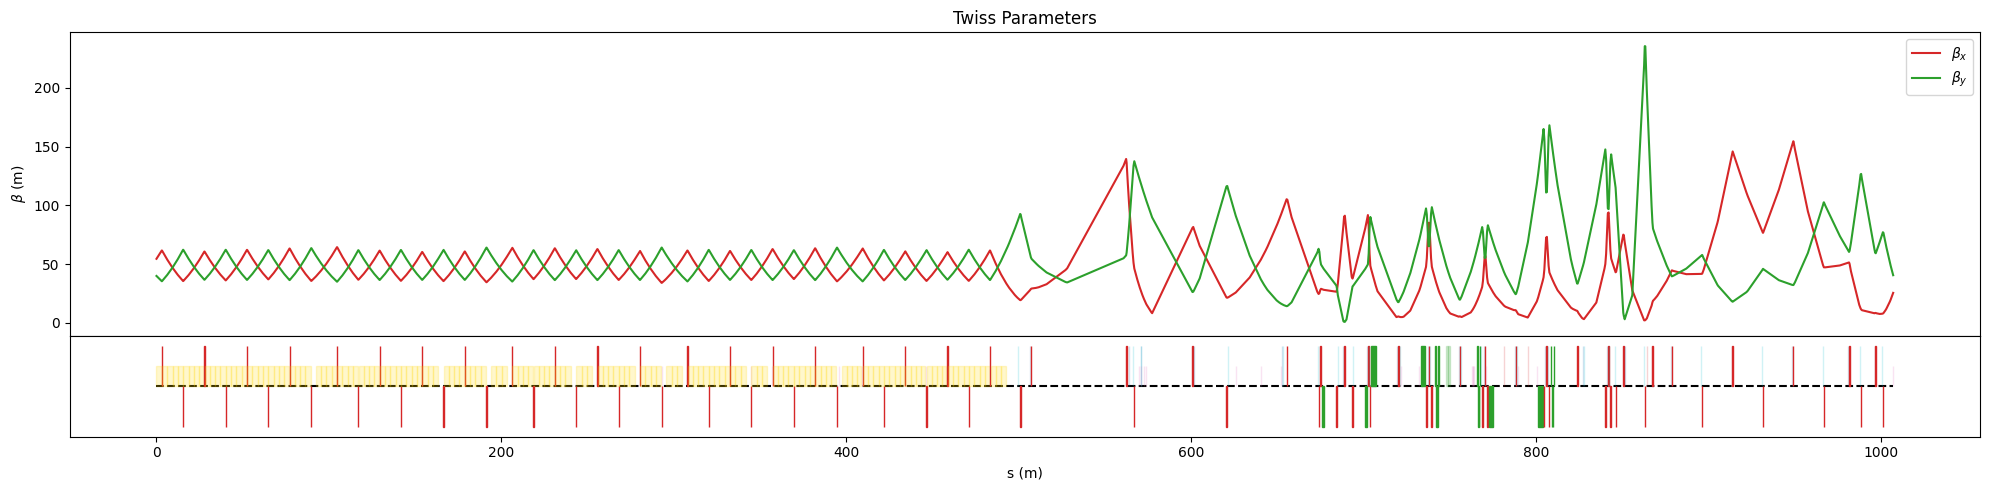

In [24]:
quad_beam = cheetah.ParameterBeam.from_twiss(
    beta_x=54.46506021,
    alpha_x=-1.09035236,
    emittance_x=3.494768647122823e-09,
    beta_y=39.84800591,
    alpha_y=0.78938986,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)

quad_segment.plot_twiss_over_lattice(quad_beam, figsize=(20, 5))

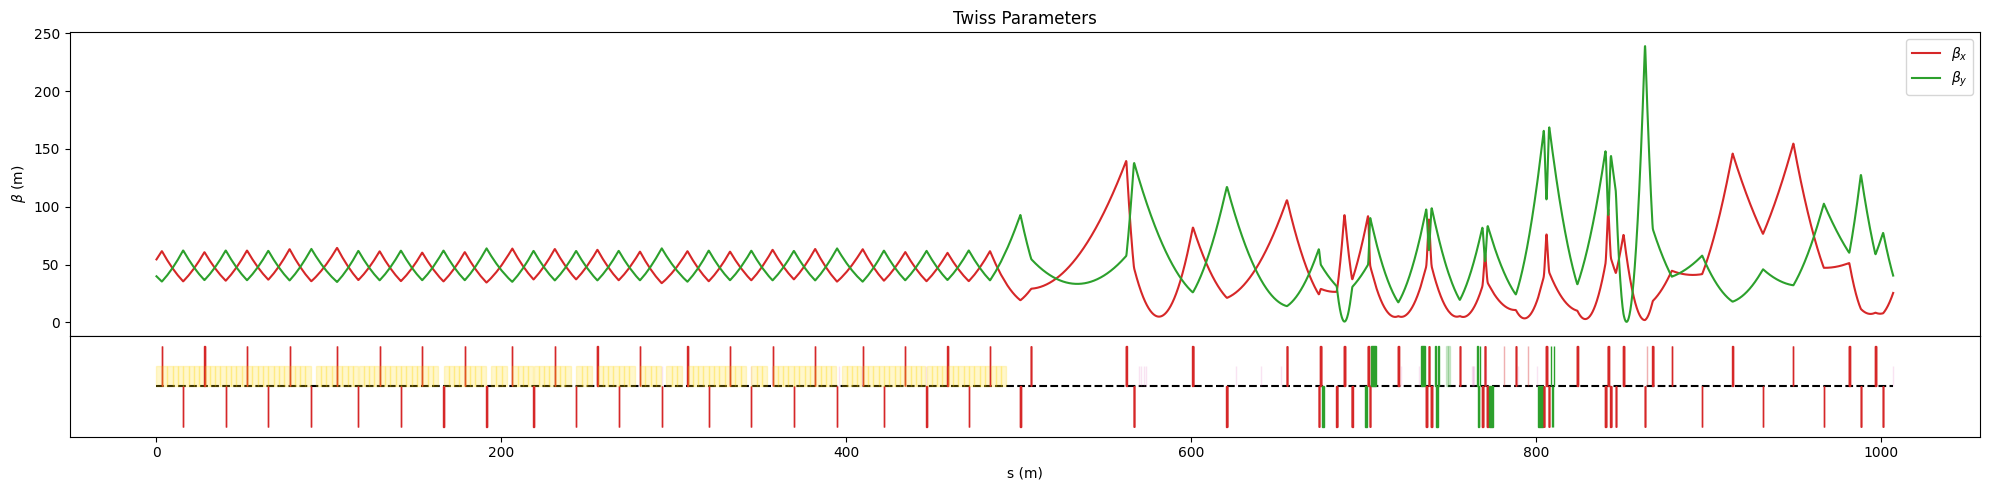

In [25]:
cheetah.Segment(quad_segment.split(resolution=0.1)).plot_twiss_over_lattice(
    quad_beam, figsize=(20, 5)
)

In [26]:
beam_stepped = quad_beam
for element in quad_segment.elements[:500]:
    beam_stepped = element.track(beam_stepped)

print(f"{element.name = }")
print(f"{beam_stepped.beta_x = }")
print(f"{beam_stepped.beta_y = }")
print(f"{beam_stepped.alpha_x = }")
print(f"{beam_stepped.alpha_y = }")

element.name = 'dwallb'
beam_stepped.beta_x = tensor(26.4113)
beam_stepped.beta_y = tensor(59.8389)
beam_stepped.alpha_x = tensor(1.3391)
beam_stepped.alpha_y = tensor(-2.0946)


In [27]:
quad_segment_replaced = cheetah.Segment(
    [
        (
            deepcopy(element)
            if not isinstance(element, cheetah.Cavity)
            else cheetah.Drift(length=element.length)
        )
        for element in quad_segment.elements
    ]
)

In [28]:
quad_segment.length, quad_segment_replaced.length

(1007.1619685082806, 1007.1619685082806)

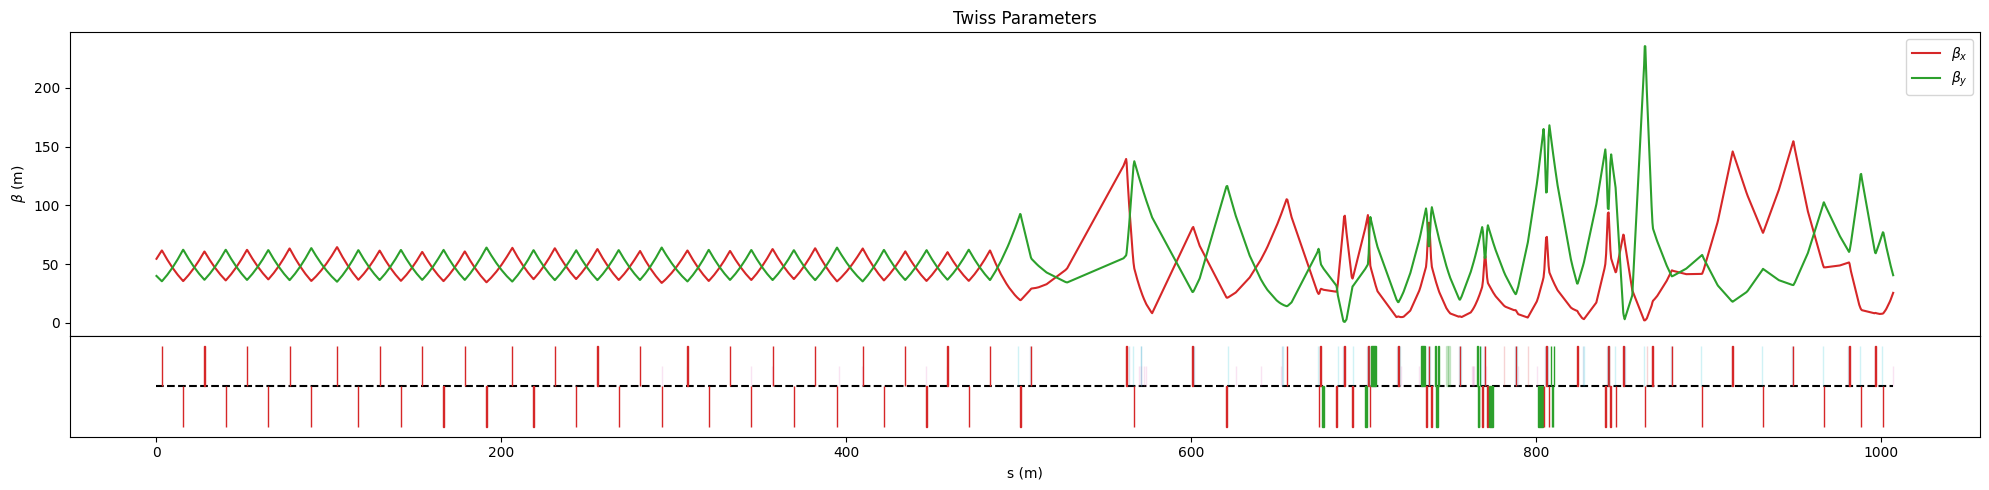

In [29]:
quad_segment_replaced.plot_twiss_over_lattice(quad_beam, figsize=(20, 5))

In [30]:
segment.l0a

Cavity(length=3.10, voltage=58010690.67, phase=1.10, frequency=2856000000.00, name="l0a", device="cpu")

In [31]:
incoming_beam = cheetah.ParticleBeam.from_twiss(
    num_particles=1_000_000,
    beta_x=0.44865302,
    beta_y=0.44865302,
    alpha_x=0.18863809,
    alpha_y=0.18863809,
    emittance_x=3.494768647122823e-09,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)
# cavity_element = cheetah.Cavity(
#     length=3.0952440, voltage=5.8010691e7, phase=-3.0555556e-3, frequency=2.8560000e9
# )
cavity_element = cheetah.Cavity(
    length=3.0952440,
    voltage=5.8010691e7,
    phase=np.degrees(-3.0555556e-3 * 2 * np.pi),
    frequency=2.8560000e9,
)

outgoing_beam = cavity_element.track(incoming_beam)

print(f"{outgoing_beam.beta_x = }")
print(f"{outgoing_beam.beta_y = }")
print(f"{outgoing_beam.alpha_x = }")
print(f"{outgoing_beam.alpha_y = }")
print(f"{outgoing_beam.energy = }")

outgoing_beam

outgoing_beam.beta_x = tensor(12.8633)
outgoing_beam.beta_y = tensor(12.8810)
outgoing_beam.alpha_x = tensor(-3.5251)
outgoing_beam.alpha_y = tensor(-3.5301)
outgoing_beam.energy = tensor(64000000.3325, dtype=torch.float64)


ParticleBeam(n=1000000, mu_x=0.000000, mu_xp=0.000000, mu_y=0.000000, mu_yp=0.000000, sigma_x=0.000065, sigma_xp=0.000018, sigma_y=0.000065, sigma_yp=0.000019, sigma_s=0.000000, sigma_p=0.000001, energy=64000000.333)

In [32]:
print(f"{cavity_element.length = } m")
print(f"{cavity_element.voltage = } V")
print(f"{cavity_element.phase = } deg")
print(f"{cavity_element.frequency = } Hz")

cavity_element.length = 3.095244 m
cavity_element.voltage = 58010691.0 V
cavity_element.phase = -1.1000000159999999 deg
cavity_element.frequency = 2856000000.0 Hz


In [33]:
import ocelot

math_op.py: module Numba is not installed. Install it if you want speed up correlation calculations


[INFO    ] : : beam.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] : : : : : : : : high_order.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] radiation_py.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module NUMBA is not installed. Install it to speed up calculation
[INFO    ] csr.py: module PYFFTW is not installed. Install it to speed up calculation.
[INFO    ] csr.py: module NUMEXPR is not installed. Install it to speed up calculation
[INFO    ] wake3D.py: module NUMBA is not installed. Install it to speed up calculation


initializing ocelot...
import: module NUMBA is not installed. Install it to speed up calculation
import: module PYFFTW is not installed. Install it to speed up calculation
import: module NUMEXPR is not installed. Install it to speed up calculation


In [34]:
tws = ocelot.Twiss()
tws.beta_x = 0.44865302
tws.beta_y = 0.44865302
tws.alpha_x = 0.18863809
tws.alpha_y = 0.18863809
tws.emit_x = 3.494768647122823e-09
tws.emit_y = 3.497810737006068e-09
tws.gamma_x = (1 + tws.alpha_x**2) / tws.beta_x
tws.gamma_y = (1 + tws.alpha_y**2) / tws.beta_y
tws.E = 6e-3

p_array = ocelot.generate_parray(tws=tws)

cell = [
    ocelot.Cavity(
        l=3.0952440,
        v=5.8010691e7 * 1e-9,
        freq=2.8560000e9,
        phi=np.degrees(-3.0555556e-3 * 2 * np.pi),
    )
]
lattice = ocelot.MagneticLattice(cell)
navigator = ocelot.Navigator(lattice=lattice)

_, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

print(derived_twiss)

[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


z = 3.095244 / 3.095244. Applied: emit_x  = 3.2778341000161075e-10
emit_y  = 3.297009271943649e-10
beta_x  = 12.85681510654396
beta_y  = 12.856815106525584
alpha_x = -3.5248686043842126
alpha_y = -3.5248686043757065
gamma_x = 1.0441698482029582
gamma_y = 1.0441698481997865
Dx      = 0.0
Dy      = 0.0
Dxp     = 0.0
Dyp     = 0.0
mux     = 0.0
muy     = 0.0
nu_x    = 0.0
nu_y    = 0.0
E       = 0.06400000033252268
s        = 0.0



In [35]:
# Cheetah
incoming_beam = cheetah.ParticleBeam.from_twiss(
    beta_x=5.91253677,
    alpha_x=3.55631308,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_x=3.494768647122823e-09,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)
cheetah_cavity = cheetah.Cavity(
    length=1.0377, voltage=0.01815975e9, frequency=1.3e9, phase=0.0
)
outgoing_beam = cheetah_cavity.track(incoming_beam)

# Ocelot
tws = ocelot.Twiss()
tws.beta_x = 5.91253677
tws.beta_y = 5.91253677
tws.alpha_x = 3.55631308
tws.alpha_y = 3.55631308
tws.emit_x = 3.494768647122823e-09
tws.emit_y = 3.497810737006068e-09
tws.gamma_x = (1 + tws.alpha_x**2) / tws.beta_x
tws.gamma_y = (1 + tws.alpha_y**2) / tws.beta_y
tws.E = 6e-3

p_array = ocelot.generate_parray(tws=tws)

cell = [ocelot.Cavity(l=1.0377, v=0.01815975, freq=1.3e9, phi=0.0)]
lattice = ocelot.MagneticLattice(cell)
navigator = ocelot.Navigator(lattice=lattice)

_, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

# Print
print("")
print(f"{outgoing_beam.beta_x = } / {derived_twiss.beta_x = }")
print(f"{outgoing_beam.beta_y = } / {derived_twiss.beta_y = }")
print(f"{outgoing_beam.alpha_x = } / {derived_twiss.alpha_x = }")
print(f"{outgoing_beam.alpha_y = } / {derived_twiss.alpha_y = }")

[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


z = 1.0377 / 1.0377. Applied: 
outgoing_beam.beta_x = tensor(0.2383) / derived_twiss.beta_x = 0.2384735250999325
outgoing_beam.beta_y = tensor(0.2382) / derived_twiss.beta_y = 0.23847352511235048
outgoing_beam.alpha_x = tensor(-1.0161) / derived_twiss.alpha_x = -1.016068759407392
outgoing_beam.alpha_y = tensor(-1.0134) / derived_twiss.alpha_y = -1.0160687593987352


In [36]:
# Cheetah
incoming_beam = cheetah.ParticleBeam.from_twiss(
    beta_x=5.91253677,
    alpha_x=3.55631308,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_x=3.494768647122823e-09,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)
cheetah_cavity = cheetah.Cavity(
    length=1.0377,
    voltage=0.01815975e9,
    frequency=1.3e9,
    phase=np.degrees(-3.0555556e-3 * 2 * np.pi),
)
outgoing_beam = cheetah_cavity.track(incoming_beam)

# Ocelot
tws = ocelot.Twiss()
tws.beta_x = 5.91253677
tws.beta_y = 5.91253677
tws.alpha_x = 3.55631308
tws.alpha_y = 3.55631308
tws.emit_x = 3.494768647122823e-09
tws.emit_y = 3.497810737006068e-09
tws.gamma_x = (1 + tws.alpha_x**2) / tws.beta_x
tws.gamma_y = (1 + tws.alpha_y**2) / tws.beta_y
tws.E = 6e-3

p_array = ocelot.generate_parray(tws=tws)

cell = [
    ocelot.Cavity(
        l=1.0377, v=0.01815975, freq=1.3e9, phi=np.degrees(-3.0555556e-3 * 2 * np.pi)
    )
]
lattice = ocelot.MagneticLattice(cell)
navigator = ocelot.Navigator(lattice=lattice)

_, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

# Print
print("")
print(f"{outgoing_beam.beta_x = } / {derived_twiss.beta_x = }")
print(f"{outgoing_beam.beta_y = } / {derived_twiss.beta_y = }")
print(f"{outgoing_beam.alpha_x = } / {derived_twiss.alpha_x = }")
print(f"{outgoing_beam.alpha_y = } / {derived_twiss.alpha_y = }")

[INFO    ] Twiss parameters have priority. sigma_{x, px, y, py} will be redefined


z = 1.0377 / 1.0377. Applied: 
outgoing_beam.beta_x = tensor(0.2381) / derived_twiss.beta_x = 0.23837266710796096
outgoing_beam.beta_y = tensor(0.2384) / derived_twiss.beta_y = 0.23837266710263216
outgoing_beam.alpha_x = tensor(-1.0161) / derived_twiss.alpha_x = -1.0155350822288927
outgoing_beam.alpha_y = tensor(-1.0159) / derived_twiss.alpha_y = -1.0155350821383675


In [39]:
MIN_LENGTH = 0.5
MAX_LENGTH = 3.142
MIN_VOLTAGE = 0.0
MAX_VOLTAGE = 0.01815975e9
MIN_FREQUENCY = 8e8
MAX_FREQUENCY = 4e9
MIN_PHASE = -5.0  # Degrees
MAX_PHASE = 5.0  # Degrees

In [46]:
incoming_beam = cheetah.ParticleBeam.from_twiss(
    num_particles=10_000,
    beta_x=5.91253677,
    alpha_x=3.55631308,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_x=3.494768647122823e-09,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)

# Scan length
cheetah_outgoing_beams_length = []
for length in np.linspace(MIN_LENGTH, MAX_LENGTH, 10):
    cheetah_cavity = cheetah.Cavity(
        length=length, voltage=0.01815975e9, frequency=1.3e9, phase=0.0
    )
    cheetah_outgoing_beams_length.append(cheetah_cavity.track(incoming_beam))

# Scan voltage
cheetah_outgoing_beams_voltage = []
for voltage in np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10):
    cheetah_cavity = cheetah.Cavity(
        length=1.0377, voltage=voltage, frequency=1.3e9, phase=0.0
    )
    cheetah_outgoing_beams_voltage.append(cheetah_cavity.track(incoming_beam))

# Scan frequency
cheetah_outgoing_beams_frequency = []
for frequency in np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10):
    cheetah_cavity = cheetah.Cavity(
        length=1.0377, voltage=0.01815975e9, frequency=frequency, phase=0.0
    )
    cheetah_outgoing_beams_frequency.append(cheetah_cavity.track(incoming_beam))

# Scan phase
cheetah_outgoing_beams_phase = []
for phase in np.linspace(MIN_PHASE, MAX_PHASE, 10):
    cheetah_cavity = cheetah.Cavity(
        length=1.0377, voltage=0.01815975e9, frequency=1.3e9, phase=phase
    )
    cheetah_outgoing_beams_phase.append(cheetah_cavity.track(incoming_beam))

In [47]:
incoming_beam = cheetah.ParticleBeam.from_twiss(
    num_particles=10_000,
    beta_x=5.91253677,
    alpha_x=3.55631308,
    beta_y=5.91253677,
    alpha_y=3.55631308,
    emittance_x=3.494768647122823e-09,
    emittance_y=3.497810737006068e-09,
    energy=6e6,
)

# Scan length
ocelot_outgoing_beams_length = []
for length in np.linspace(MIN_LENGTH, MAX_LENGTH, 10):
    cell = [ocelot.Cavity(l=length, v=0.01815975, freq=1.3e9, phi=0.0)]
    lattice = ocelot.MagneticLattice(cell)
    navigator = ocelot.Navigator(lattice=lattice)

    _, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
    derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

    ocelot_outgoing_beams_length.append(derived_twiss)


# Scan voltage
ocelot_outgoing_beams_voltage = []
for voltage in np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10):
    cell = [ocelot.Cavity(l=1.0377, v=voltage * 1e-9, freq=1.3e9, phi=0.0)]
    lattice = ocelot.MagneticLattice(cell)
    navigator = ocelot.Navigator(lattice=lattice)

    _, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
    derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

    ocelot_outgoing_beams_voltage.append(derived_twiss)

# Scan frequency
ocelot_outgoing_beams_frequency = []
for frequency in np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10):
    cell = [ocelot.Cavity(l=1.0377, v=0.01815975, freq=frequency, phi=0.0)]
    lattice = ocelot.MagneticLattice(cell)
    navigator = ocelot.Navigator(lattice=lattice)

    _, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
    derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

    ocelot_outgoing_beams_frequency.append(derived_twiss)

# Scan phase
ocelot_outgoing_beams_phase = []
for phase in np.linspace(MIN_PHASE, MAX_PHASE, 10):
    cell = [ocelot.Cavity(l=1.0377, v=0.01815975, freq=1.3e9, phi=phase)]
    lattice = ocelot.MagneticLattice(cell)
    navigator = ocelot.Navigator(lattice=lattice)

    _, outgoing_parray = ocelot.track(lattice, deepcopy(p_array), navigator)
    derived_twiss = ocelot.cpbd.beam.get_envelope(outgoing_parray)

    ocelot_outgoing_beams_phase.append(derived_twiss)

z = 1.0377 / 1.0377. Applied: 4444444444446. Applied: 

In [56]:
bmad_beta_x_length = [
    1.57607785,
    0.24924057,
    0.35954466,
    1.91798906,
    4.85839068,
    9.09268702,
    14.53016864,
    21.08444445,
    28.67575709,
    37.23144341,
]
bmad_beta_y_length = [
    1.57607785,
    0.24924057,
    0.35954466,
    1.91798906,
    4.85839068,
    9.09268702,
    14.53016864,
    21.08444445,
    28.67575709,
    37.23144341,
]

np.linspace(MIN_LENGTH, MAX_LENGTH, 10)

array([0.5       , 0.79355556, 1.08711111, 1.38066667, 1.67422222,
       1.96777778, 2.26133333, 2.55488889, 2.84844444, 3.142     ])

In [58]:
bmad_beta_x_voltage = [
    1.01729176,
    0.95397588,
    0.80934467,
    0.63361881,
    0.46047155,
    0.31298502,
    0.20725501,
    0.15462923,
    0.16314367,
    0.23847352,
]
bmad_beta_y_voltage = [
    1.01729176,
    0.95397588,
    0.80934467,
    0.63361881,
    0.46047155,
    0.31298502,
    0.20725501,
    0.15462923,
    0.16314367,
    0.23847352,
]

np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10)

array([       0.,  2017750.,  4035500.,  6053250.,  8071000., 10088750.,
       12106500., 14124250., 16142000., 18159750.])

In [60]:
bmad_beta_x_frequency = [
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
]
bmad_beta_y_frequency = [
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
    0.23847352,
]

np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10)

array([8.00000000e+08, 1.15555556e+09, 1.51111111e+09, 1.86666667e+09,
       2.22222222e+09, 2.57777778e+09, 2.93333333e+09, 3.28888889e+09,
       3.64444444e+09, 4.00000000e+09])

In [63]:
bmad_beta_x_phase = [
    0.23640452,
    0.23721818,
    0.23783162,
    0.23824209,
    0.23844779,
    0.23844779,
    0.23824209,
    0.23783162,
    0.23721818,
    0.23640452,
]
bmad_beta_y_phase = [
    0.23640452,
    0.23721818,
    0.23783162,
    0.23824209,
    0.23844779,
    0.23844779,
    0.23824209,
    0.23783162,
    0.23721818,
    0.23640452,
]

-np.deg2rad(np.linspace(MIN_PHASE, MAX_PHASE, 10)) / (2 * np.pi)

array([ 0.01388889,  0.01080247,  0.00771605,  0.00462963,  0.00154321,
       -0.00154321, -0.00462963, -0.00771605, -0.01080247, -0.01388889])

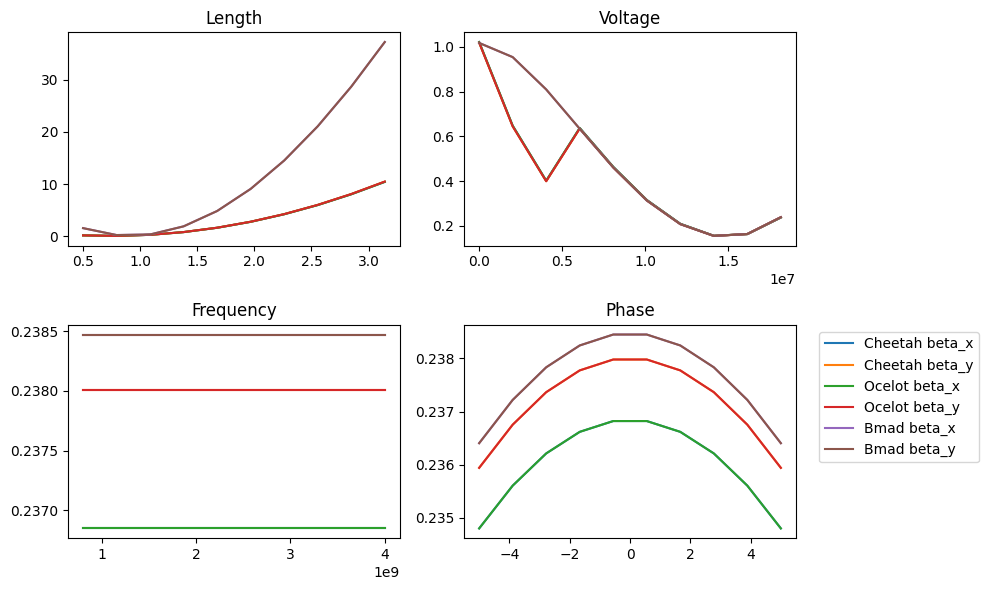

In [67]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.title("Length")
plt.plot(
    np.linspace(MIN_LENGTH, MAX_LENGTH, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_length],
    label="Cheetah beta_x",
)
plt.plot(
    np.linspace(MIN_LENGTH, MAX_LENGTH, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_length],
    label="Cheetah beta_y",
)
plt.plot(
    np.linspace(MIN_LENGTH, MAX_LENGTH, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_length],
    label="Ocelot beta_x",
)
plt.plot(
    np.linspace(MIN_LENGTH, MAX_LENGTH, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_length],
    label="Ocelot beta_y",
)
plt.plot(
    np.linspace(MIN_LENGTH, MAX_LENGTH, 10),
    bmad_beta_x_length,
    label="Bmad beta_x",
)
plt.plot(
    np.linspace(MIN_LENGTH, MAX_LENGTH, 10),
    bmad_beta_y_length,
    label="Bmad beta_y",
)
plt.subplot(2, 2, 2)
plt.title("Voltage")
plt.plot(
    np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_voltage],
    label="Cheetah beta_x",
)
plt.plot(
    np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_voltage],
    label="Cheetah beta_y",
)
plt.plot(
    np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_voltage],
    label="Ocelot beta_x",
)
plt.plot(
    np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_voltage],
    label="Ocelot beta_y",
)
plt.plot(
    np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10),
    bmad_beta_x_voltage,
    label="Bmad beta_x",
)
plt.plot(
    np.linspace(MIN_VOLTAGE, MAX_VOLTAGE, 10),
    bmad_beta_y_voltage,
    label="Bmad beta_y",
)
plt.subplot(2, 2, 3)
plt.title("Frequency")
plt.plot(
    np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_frequency],
    label="Cheetah beta_x",
)
plt.plot(
    np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_frequency],
    label="Cheetah beta_y",
)
plt.plot(
    np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_frequency],
    label="Ocelot beta_x",
)
plt.plot(
    np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_frequency],
    label="Ocelot beta_y",
)
plt.plot(
    np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10),
    bmad_beta_x_frequency,
    label="Bmad beta_x",
)
plt.plot(
    np.linspace(MIN_FREQUENCY, MAX_FREQUENCY, 10),
    bmad_beta_y_frequency,
    label="Bmad beta_y",
)
plt.subplot(2, 2, 4)
plt.title("Phase")
plt.plot(
    np.linspace(MIN_PHASE, MAX_PHASE, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_phase],
    label="Cheetah beta_x",
)
plt.plot(
    np.linspace(MIN_PHASE, MAX_PHASE, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_phase],
    label="Cheetah beta_y",
)
plt.plot(
    np.linspace(MIN_PHASE, MAX_PHASE, 10),
    [beam.beta_x for beam in cheetah_outgoing_beams_phase],
    label="Ocelot beta_x",
)
plt.plot(
    np.linspace(MIN_PHASE, MAX_PHASE, 10),
    [beam.beta_y for beam in cheetah_outgoing_beams_phase],
    label="Ocelot beta_y",
)
plt.plot(
    np.linspace(MIN_PHASE, MAX_PHASE, 10),
    bmad_beta_x_phase,
    label="Bmad beta_x",
)
plt.plot(
    np.linspace(MIN_PHASE, MAX_PHASE, 10),
    bmad_beta_y_phase,
    label="Bmad beta_y",
)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()